<a href="https://colab.research.google.com/github/nyvee/Image-Classification-GA/blob/main/ML_GA_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification using RandomForest Classifier and GA**

**Importing Library**

In [ ]:
import numpy as np                                                                                      # untuk operasi vektor dan matriks
import random                                                                                           # untuk mengacak data
import time                                                                                             # untuk menghitung waktu
import seaborn as sns                                                                                   # untuk plot grafik
import matplotlib.pyplot as plt                                                                         # untuk plot grafik
from sklearn.model_selection import train_test_split                                                    # untuk membagi data menjadi data latih dan data uji
from sklearn.ensemble import RandomForestClassifier                                                     # untuk membuat model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix   # untuk menghitung akurasi, presisi, recall, dan f1-score
from keras.preprocessing.image import ImageDataGenerator                                                # untuk augmentasi gambar

**Image Data Loading and Augmentation**
- ImageDataGenerator: Konfigurasi untuk merescale nilai pixel dan melakukan pemisahan untuk validasi.

In [ ]:
data_path_train = "drive/MyDrive/UAS_AI/Dataset/train"
data_path_test = "drive/MyDrive/UAS_AI/Dataset/test"
img_w, img_h = 300, 300
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

**Fungsi untuk memuat Data**
- Berfungsi untuk memuat data yang ada di directory(path).
- Mengekstrak label(class).
- Menginisialisasi array X, y.
- Memuat data image ke array X dan data label ke array y.
- Mengonversi gambar(2D) menjadi array 1D di X_reshaped.

In [ ]:
def generate_data(data_generator, data_path, subset):
    data_set = data_generator.flow_from_directory(
        data_path,
        target_size=(img_h, img_w),
        batch_size=32,
        class_mode='categorical',
        subset=subset
    )
    label_names = data_set.class_indices
    dict_labels = {name: index for name, index in label_names.items()}
    reverse_dict_labels = {index: name for name, index in label_names.items()}
    print(dict_labels)

    X, y = [], []

    for _ in range(len(data_set)):
        batch = data_set.next()
        images, labels = batch[0], batch[1]
        X.extend(images)
        y.extend(np.argmax(labels, axis=1))

    X = np.array(X)
    X_reshaped = X.reshape(X.shape[0], -1)
    y = np.array(y)

    return X, X_reshaped, y, reverse_dict_labels

- Memanggil fungsi *generate_data* untuk *training*
- Menjalankan fungsi *train_test_split* dari *Scikit-learn* untuk membagi dataset menjadi 2 dan pengalokasian 20% data untuk data validasi.
- Memanggil fungsi *generate_data* untuk *test*

In [ ]:
X, _, y, _ = generate_data(datagen, data_path_train, 'training')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, _, y_test, reverse_dict_labels = generate_data(datagen, data_path_test, subset=None)

Found 1567 images belonging to 5 classes.
{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}
Found 330 images belonging to 5 classes.
{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}


In [ ]:
def normalize_data(X_train, X_val, X_test):
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_val /= 255
    X_test /= 255
    return X_train, X_val, X_test

## **ALGORITMA GENETIKA**

**Fungsi untuk menginisialisasi populasi**
- Fungsi *initialize_population* ini digunakan untuk menghasilkan populasi vektor biner (kromosom) yang mewakili individu dalam algoritma genetika

In [ ]:
def initialize_population(population_size, feature_count):
    return [np.random.randint(2, size=feature_count) for _ in range(population_size)]

**Fungsi untuk menghitung nilai *Fitness***
- Penggunaan fungsi *RandomForestClassifier* dengan parameter *n_estimators* dan *random_state* sebagai model klasifikasi yang akan dioptimalkan dengan algoritma genetika (GA).

In [ ]:
def fitness(chromosome, X_train, y_train, X_val, y_val):
    classifier = RandomForestClassifier(n_estimators=20, random_state=None) # n_estimators=10 (default on 100), random_state=20 (default on None)
    # n_estimators=20 digunakan sebagai jumlah pohon keputusan dalam model Random Forest
    # random_state=10 digunakan untuk memastikan hasil yang dapat direproduksi

    selected_features = X_train[:, chromosome == 1]
    selected_val_features = X_val[:, chromosome == 1]
    # Memilih fitur-fitur yang sesuai dengan kromosom yang bernilai 1

    classifier.fit(selected_features, y_train) # Melatih model dengan fitur-fitur yang telah dipilih
    predictions = classifier.predict(selected_val_features) # Memprediksi data validasi dengan model yang telah dilatih
    accuracy = accuracy_score(y_val, predictions) # Menghitung akurasi dari prediksi

    return accuracy, predictions # Mengembalikan akurasi dan prediksi

**Fungsi untuk mutasi chromosome**

In [ ]:
def mutate(chromosome, mutation_rate):
    mutation_mask = np.random.rand(len(chromosome)) < mutation_rate
    chromosome[mutation_mask] = 1 - chromosome[mutation_mask]
    return chromosome

**Fungsi seleksi**
- Fungsi *roulette_wheel_selection* digunakan untuk menyeleksi menggunakan metode roulette wheel. Penggunaan metode roulette wheel dinilai lebih menggambarkan seleksi secara natural.

In [ ]:
def tournament_selection(scores, tournament_size):
    best_score_index = np.argmax([scores[np.random.choice(len(scores))][1] for _ in range(tournament_size)])
    return best_score_index

In [ ]:
def uniform_crossover(parent1, parent2):
    child = np.zeros_like(parent1)
    for i in range(len(parent1)):
        if np.random.rand() < 0.5:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

**Fungsi Evolusi Genetika**
- Fungsi *evolve* akan melakukan proses evolusi genetika.
- Metode crossover yang digunakan adalah single point crossover.
- Metode mutasi yang digunakan adalah random mutation.
- Fungsi ini akan mengembalikan kromosom terbaik, akurasi terbaik, dan waktu training.

In [ ]:
# def evolve(population, X_train, y_train, X_val, y_val, generations, mutation_rate, tournament_size):
#     feature_count = X_train.shape[1]
#     best_accuracies = []
#     training_times = []

#     for generation in range(generations):
#         start_time = time.time()
#         scores = []

#         for chromosome in population:
#             accuracy, _ = fitness(chromosome, X_train, y_train, X_val, y_val)
#             scores.append((chromosome, accuracy))

#         new_population = []

#         # Sort the population based on fitness scores
#         scores.sort(key=lambda x: x[1], reverse=True)

#         # Elitism: Select the top individuals directly for the next generation
#         new_population = [scores[i][0] for i in range(2)]

#         for _ in range(len(population)):
#             selected_index = tournament_selection(scores, tournament_size)
#             new_population.append(scores[selected_index][0])

#         population = new_population.copy()

#         while len(new_population) < len(population):
#             parent1 = random.choice(population)
#             parent2 = random.choice(population)

#             child = uniform_crossover(parent1, parent2)
#             mutate(child, mutation_rate)
#             population[i] = child
#             new_population.append(child)

#         end_time = time.time()
#         training_time = end_time - start_time
#         best_accuracies.append(max(scores, key=lambda x: x[1])[1])
#         training_times.append(training_time)

#         print(f"Generation {generation + 1}, Best Fitness: {max(scores, key=lambda x: x[1])[1]}, Time: {training_time}")

#     best_chromosome, _ = max(scores, key=lambda x: x[1])
#     return best_chromosome, best_accuracies, training_times
# def evolve(population, X_train, y_train, X_val, y_val, generations, mutation_rate, tournament_size):
#     feature_count = X_train.shape[1]
#     best_accuracies = []
#     training_times = []

#     for generation in range(generations):
#         start_time = time.time()
#         scores = []

#         for chromosome in population:
#             accuracy, _ = fitness(chromosome, X_train, y_train, X_val, y_val)
#             scores.append((chromosome, accuracy))

#         # Sort the population based on fitness scores
#         scores.sort(key=lambda x: x[1], reverse=True)

#         # Elitism: Select the top individuals directly for the next generation
#         new_population = [scores[i][0] for i in range(2)]

#         # Generate offspring through uniform crossover and mutation to form the rest of the new population
#         while len(new_population) < len(population):
#             parent1 = random.choice(population)
#             parent2 = random.choice(population)

#             child = uniform_crossover(parent1, parent2)
#             mutate(child, mutation_rate)
#             new_population.append(child)

#         population = new_population.copy()

#         end_time = time.time()
#         training_time = end_time - start_time
#         best_accuracies.append(max(scores, key=lambda x: x[1])[1])
#         training_times.append(training_time)

#         print(f"Generation {generation + 1}, Best Fitness: {max(scores, key=lambda x: x[1])[1]}, Time: {training_time}")

#     best_chromosome, _ = max(scores, key=lambda x: x[1])
#     return best_chromosome, best_accuracies, training_times


In [ ]:
#ENHANCED ELITISM = child akan dimasukkan kedalam populasi parent
def evolve(population, X_train, y_train, X_val, y_val, generations, mutation_rate):
    feature_count = X_train.shape[1]
    best_accuracies = []
    training_times = []

    for generation in range(generations):
        start_time = time.time()
        scores = []

        for chromosome in population:
            accuracy, _ = fitness(chromosome, X_train, y_train, X_val, y_val)
            scores.append((chromosome, accuracy))

        # Sort the population based on fitness scores
        scores.sort(key=lambda x: x[1], reverse=True)

        # Elitism: Select the top individuals directly for the next generation
        new_population = [scores[i][0] for i in range(2)]

        # Generate offspring through crossover and mutation to form the rest of the new population
        while len(new_population) < len(population):
            parent1 = random.choice(population)
            parent2 = random.choice(population)

            crossover_point = np.random.randint(feature_count)
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            mutate(child, mutation_rate)
            new_population.append(child)

        population = new_population.copy()

        end_time = time.time()
        training_time = end_time - start_time
        best_accuracies.append(max(scores, key=lambda x: x[1])[1])
        training_times.append(training_time)

        print(f"Generation {generation + 1}, Best Fitness: {max(scores, key=lambda x: x[1])[1]}, Time: {training_time}")

    best_chromosome, _ = max(scores, key=lambda x: x[1])
    return best_chromosome, best_accuracies, training_times

- Inisialisasi 3 Parameter yang akan digunakan di GA

In [ ]:
population_size = 10 # Jumlah kromosom dalam populasi (semakin besar semakin lama proses)
generations = 20     # Jumlah generasi (semakin besar semakin lama proses)
mutation_rate = 0.1  # Peluang terjadinya mutasi pada kromosom (semakin besar semakin banyak fitur yang dimutasi)
tournament_size = 5

**Memulai proses Algoritma Genetika**
- Menginisialisasi populasi dengan fungsi *initialize_population* dan dengan parameter yang dibutuhkan.
- Memulai fungsi *evolve* dengan 3 parameter yang telah disiapkan sebelumnya.

In [ ]:
num_samples_train, num_samples_val = X_train.shape[0], X_val.shape[0]
X_train_reshaped, X_val_reshaped = X_train.reshape(num_samples_train, -1), X_val.reshape(num_samples_val, -1)

population = initialize_population(population_size, X_train_reshaped.shape[1])
best_chromosome, best_accuracies, training_times = evolve(population, X_train_reshaped, y_train, X_val_reshaped, y_val, generations, mutation_rate)

Generation 1, Best Fitness: 0.6847133757961783, Time: 80.17007446289062
Generation 2, Best Fitness: 0.6910828025477707, Time: 79.5802710056305
Generation 3, Best Fitness: 0.7070063694267515, Time: 77.2586395740509
Generation 4, Best Fitness: 0.6910828025477707, Time: 79.24945521354675
Generation 5, Best Fitness: 0.6751592356687898, Time: 76.98983407020569
Generation 6, Best Fitness: 0.6656050955414012, Time: 79.2277307510376
Generation 7, Best Fitness: 0.6910828025477707, Time: 78.88170742988586
Generation 8, Best Fitness: 0.6751592356687898, Time: 77.79772758483887
Generation 9, Best Fitness: 0.678343949044586, Time: 80.09906458854675
Generation 10, Best Fitness: 0.697452229299363, Time: 78.5385205745697
Generation 11, Best Fitness: 0.6751592356687898, Time: 80.88434290885925
Generation 12, Best Fitness: 0.6847133757961783, Time: 80.35899567604065
Generation 13, Best Fitness: 0.697452229299363, Time: 80.33471488952637
Generation 14, Best Fitness: 0.6847133757961783, Time: 78.567461013

**Plotting**
- Membuat grafik nilai Fitness terbaik dan waktu yang dibutuhkan untuk setiap generasinya.
- Menghitung rata-rata waktu yang dibutuhkan 1 generasi.

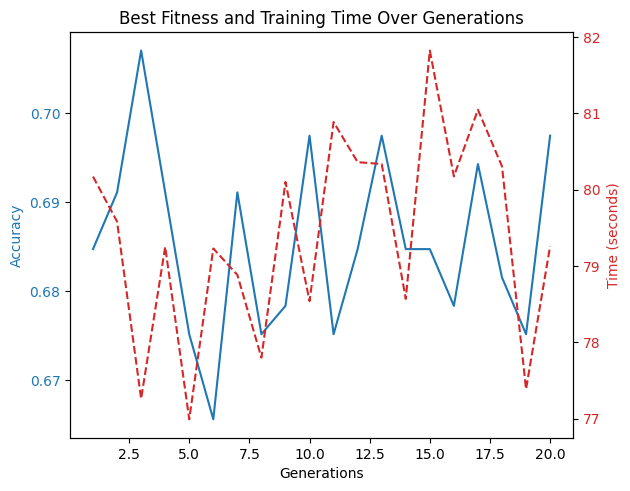

The average training time over 20 generations is 79.40 seconds.


In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Generations')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(1, generations+1), best_accuracies, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Time (seconds)', color=color)
ax2.plot(range(1, generations+1), training_times, color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Best Fitness and Training Time Over Generations')
plt.show()

average_time = format(np.mean(training_times), '.2f')

print(f"The average training time over {generations} generations is {average_time} seconds.")

- Langkah post-processing untuk Reshape data test dan mengekstrak fitur dari data latih, validasi, dan uji yang telah diubah bentuk.

In [ ]:
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [ ]:
best_chromosome = best_chromosome[:X_train_reshaped.shape[1]]
selected_feature_indices = np.where(best_chromosome == 1)[0]

selected_features = X_train_reshaped[:, selected_feature_indices]

num_samples_val = X_val_reshaped.shape[0]
selected_val_features = X_val_reshaped[:, selected_feature_indices]

num_samples_test = X_test_reshaped.shape[0]
selected_test_features = X_test_reshaped[:, selected_feature_indices]

**Training Model**
- Fungsi *trainandevalmodel* untuk melatih model klasifikasi menggunakan RandomForestClassifier dan mengevaluasi kinerja model pada data validasi dan uji.

In [ ]:
def trainandevalmodel(X_train, y_train, X_val, y_val, X_test, y_test):
    classifier = RandomForestClassifier(n_estimators=100, random_state=100)
    classifier.fit(X_train, y_train)

    # Predictions on the validation set
    predictions_val = classifier.predict(X_val)

    # Confusion matrix
    cm = confusion_matrix(y_val, predictions_val)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Calculate specificity for each class
    specificity = []
    for i in range(cm.shape[0]):
        tn = cm[i,i]
        fp = cm[i,:].sum() - tn
        fn = cm[:,i].sum() - tn
        tp = cm.sum() - tn - fp - fn
        specificity.append(tn / (tn + fp))

    # Performance on the validation set
    accuracy_val = accuracy_score(y_val, predictions_val)
    precision_val = precision_score(y_val, predictions_val, average='weighted')
    recall_val = recall_score(y_val, predictions_val, average='weighted')
    f1_val = f1_score(y_val, predictions_val, average='weighted')
    specificity_val = np.mean(specificity)

    print("Validation Metrics:")
    print(f"Accuracy: {accuracy_val}")
    print(f"Precision: {precision_val}")
    print(f"Recall: {recall_val}")
    print(f"F1 Score: {f1_val}")
    print(f"Specificity: {specificity_val}")

    # Predictions on the test set
    predictions_test = classifier.predict(X_test)

    # Performance on the test set
    accuracy_test = round(accuracy_score(y_test, predictions_test) * 100, 2)

    print("\nTesting Metrics:")
    print(f"Testing Accuracy: {accuracy_test}%")

    return classifier

- Menjalankan fungsi *trainandevalmodel*

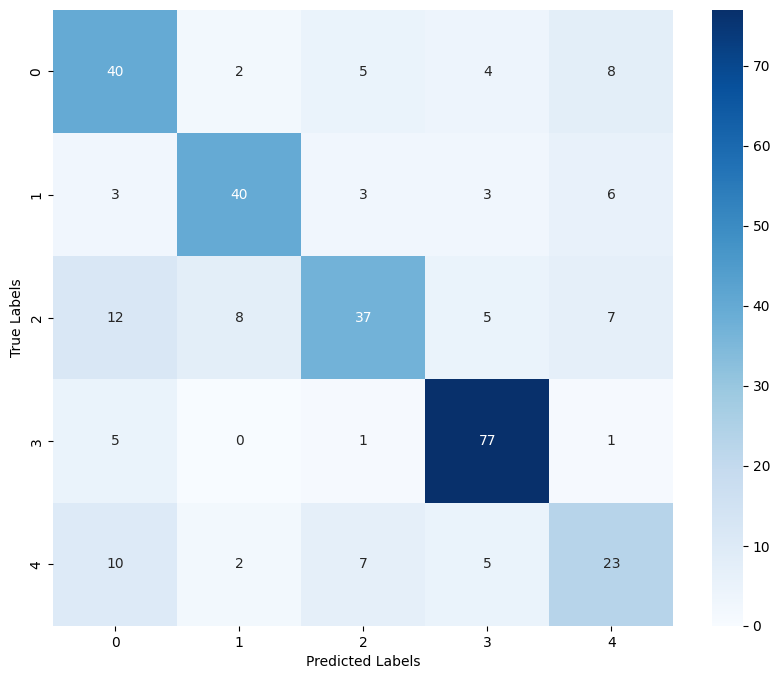

Validation Metrics:
Accuracy: 0.6910828025477707
Precision: 0.6911545293097223
Recall: 0.6910828025477707
F1 Score: 0.6870613341837221
Specificity: 0.6694998163639879

Testing Metrics:
Testing Accuracy: 64.24%


In [ ]:
classifier = trainandevalmodel(selected_features, y_train, selected_val_features, y_val, selected_test_features, y_test)

In [ ]:
num_samples_test = selected_test_features.shape[0]
selected_test_features_reshaped = selected_test_features.reshape(num_samples_test, -1)
test_predictions = classifier.predict(selected_test_features_reshaped)

**Contoh Prediksi pada data Uji**

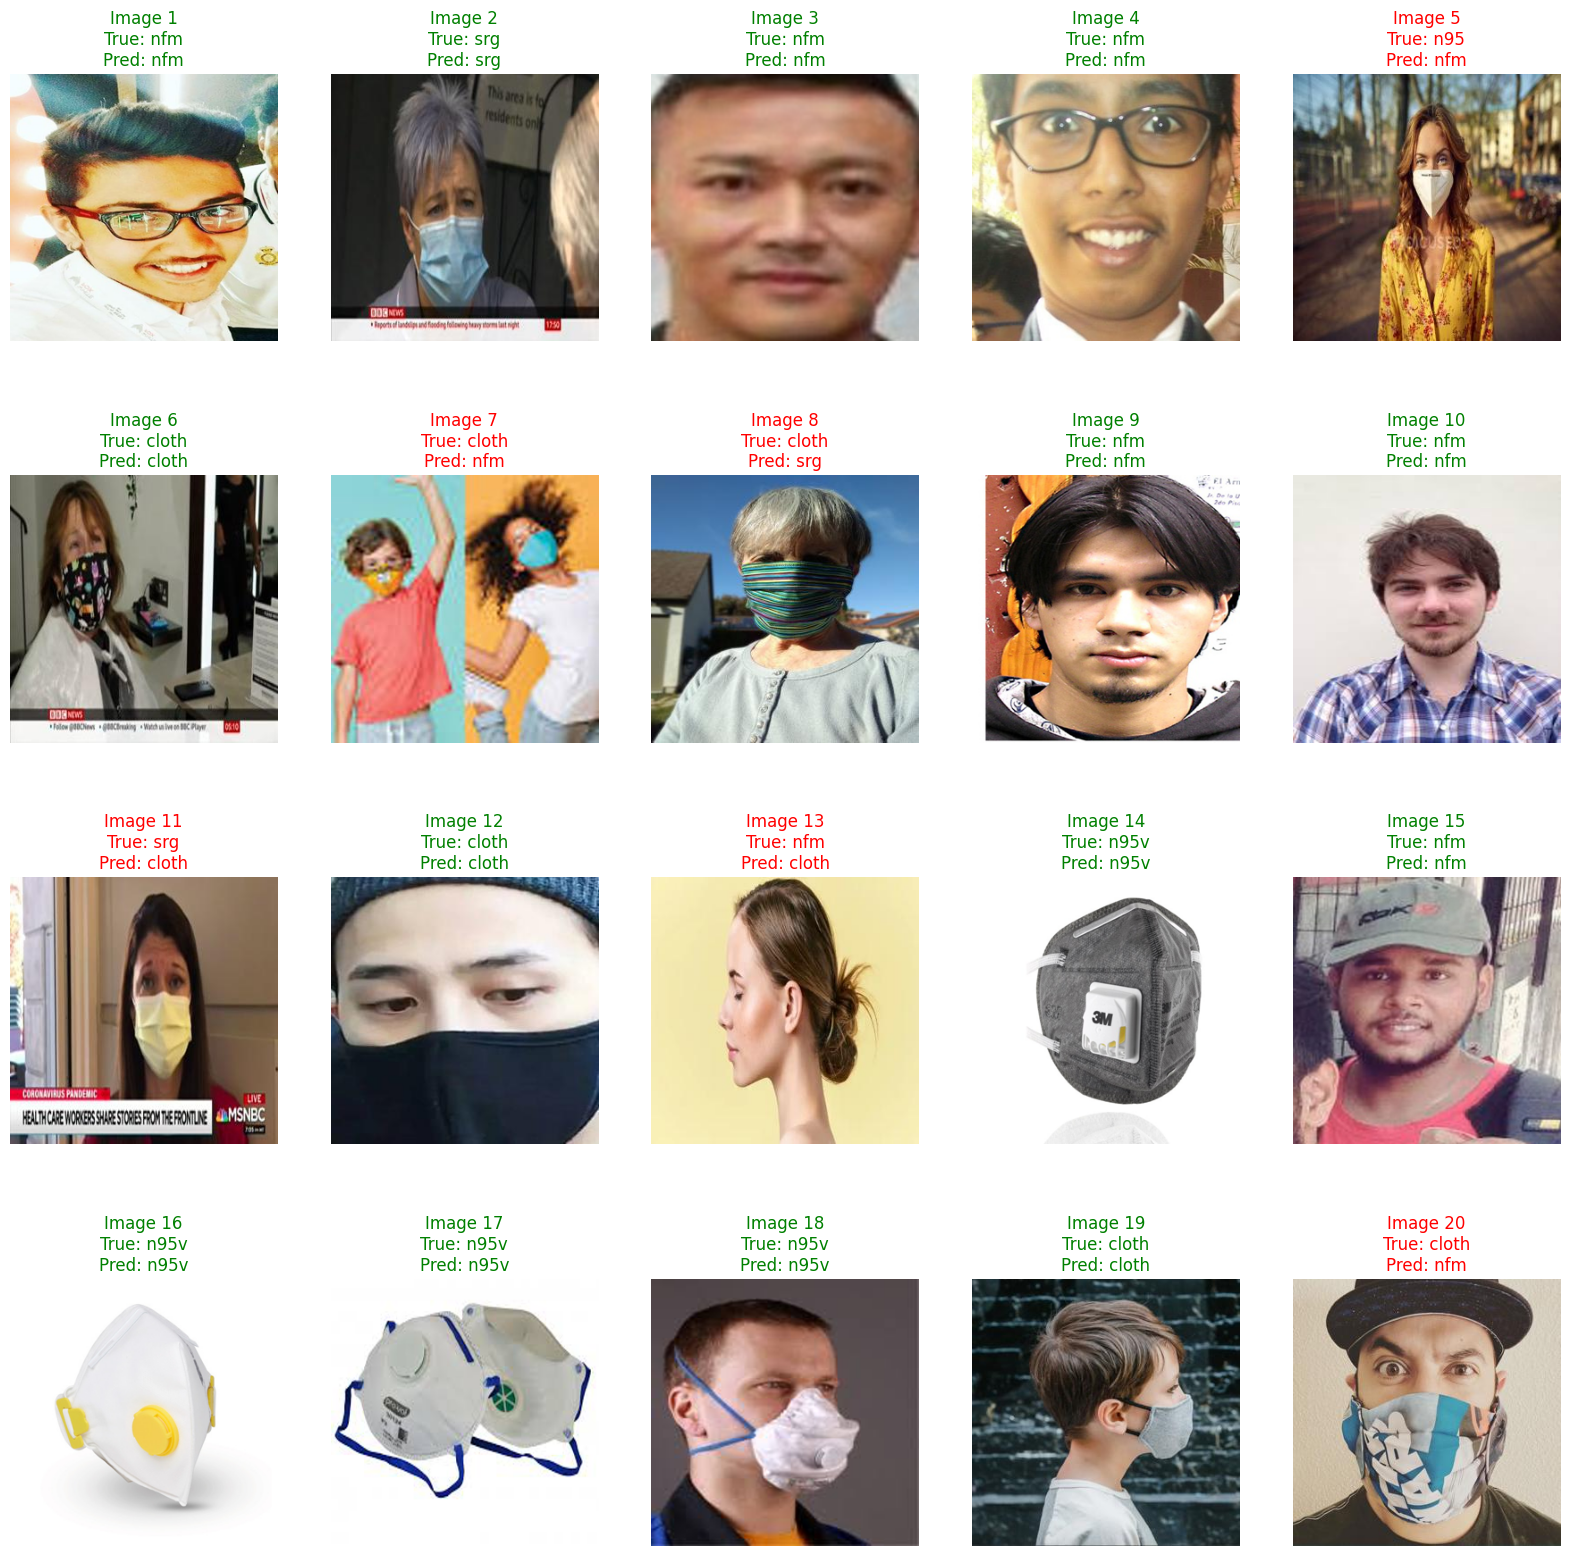

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))

for i in range(20):
    img = X_test[i]
    prediction_label = reverse_dict_labels[test_predictions[i]]
    actual_label = reverse_dict_labels[y_test[i]]
    row, col = i // 5, i % 5
    if prediction_label == actual_label:
        axes[row, col].set_title(f"Image {i+1}\nTrue: {actual_label}\nPred: {prediction_label}", color='green')
    else:
        axes[row, col].set_title(f"Image {i+1}\nTrue: {actual_label}\nPred: {prediction_label}", color='red')
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
